### Stroke Factors Analysis with Random Forest Classifier

### Purpose

### 1. Import required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay

### 2. Load Dataset

In [3]:
# Load data
df = pd.read_csv('../healthcare-dataset-stroke-data.csv')
X = df.drop(columns=['id', 'stroke'])
y = df['stroke']

In [4]:
# Define column groups: numerical, categorical
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                    'work_type', 'Residence_type', 'smoking_status']

### 3. Create preprocessing pipelines

In [5]:
# Numerical: Iterative Imputation
num_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42))
])

# Categorical: Impute missing (if any) and One-Hot Encode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Combine both into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)

# Define the full model pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

### 4. Hyperparameter tuning

In [6]:
# GridSearch setup
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=StratifiedKFold(5), 
    scoring=make_scorer(fbeta_score, beta=2),
    n_jobs=-1
)
grid_search

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__class_weight': ['balanced', 'balanced_subsample'], 'classifier__max_depth': [10, 20], 'classifier__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","make_scorer(f...dict', beta=2)"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo...shuffle=False)
,"verbose verbose: intControls the verbosity: the higher, 

### 5. Train the model

In [7]:
# Fit the model
grid_search.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__class_weight': ['balanced', 'balanced_subsample'], 'classifier__max_depth': [10, 20], 'classifier__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","make_scorer(f...dict', beta=2)"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo...shuffle=False)
,"verbose verbose: intControls the verbosity: the higher, 

### 6. Obtain the best model, predict, and apply threshold

In [8]:
# Get the Best Model from the GridSearch
best_model = grid_search.best_estimator_

# Get Predicted Probabilities
# Use the pipeline to transform X_test and get probabilities
# For highly imbalanced data set, using predict_proba an adjusting the threshold.
y_probs = best_model.predict_proba(X_test)[:, 1]

best_model

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

### 7. Use default threshold

In [9]:
# Apply the 0.2 Threshold
y_pred_tuned = (y_probs >= 0.5).astype(int)
print(f"Best Parameters: {grid_search.best_params_}")
print("\nClassification Report (Pipeline + GridSearch):")
print(classification_report(y_test, y_pred_tuned))

Best Parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 10, 'classifier__n_estimators': 100}

Classification Report (Pipeline + GridSearch):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.15      0.14      0.14        50

    accuracy                           0.92      1022
   macro avg       0.55      0.55      0.55      1022
weighted avg       0.92      0.92      0.92      1022



Recall, also known as sensitivity, focuses on finding all the true positives. In healthcare, missing a positive case, like failing to detect a disease, can be catastrophic. That's why recall often matters more than precision in medical applications. There's always a trade-off between precision and recall.
<br> For the default threshold = 0.5, the recall value is very low 0.14. In this case a lower threshold would give better results.

### 8. Adjust the threshold

In [10]:
# Apply the 0.2 Threshold
y_pred_tuned = (y_probs >= 0.2).astype(int)
print(f"Best Parameters: {grid_search.best_params_}")
print("\nClassification Report (Pipeline + GridSearch):")
print(classification_report(y_test, y_pred_tuned))

Best Parameters: {'classifier__class_weight': 'balanced_subsample', 'classifier__max_depth': 10, 'classifier__n_estimators': 100}

Classification Report (Pipeline + GridSearch):
              precision    recall  f1-score   support

           0       0.98      0.70      0.82       972
           1       0.12      0.78      0.21        50

    accuracy                           0.71      1022
   macro avg       0.55      0.74      0.51      1022
weighted avg       0.94      0.71      0.79      1022



### 9. The confusion matrix

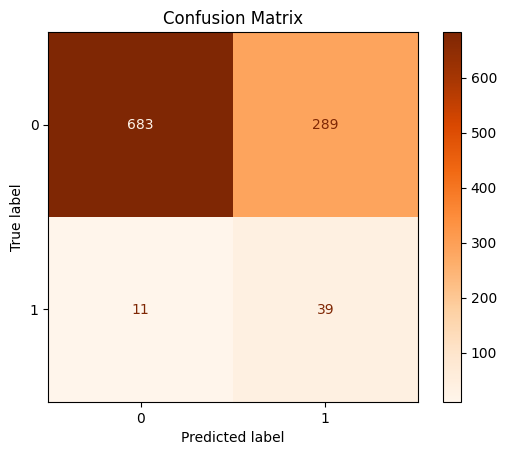

In [11]:
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Oranges")
plt.title("Confusion Matrix")
plt.savefig(f"images/RandomForest_confusion_matrix.png", bbox_inches="tight")
plt.show()

### 10. Precision-Recall Curve

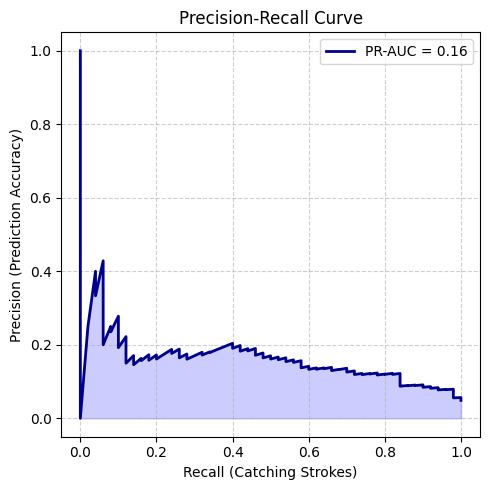

In [12]:

plt.figure(figsize=(5, 5))
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, color='darkblue', lw=2, label=f'PR-AUC = {pr_auc:.2f}')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall (Catching Strokes)')
plt.ylabel('Precision (Prediction Accuracy)')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig(f"images/precision_recall_curve.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

### 11 Top ten important features

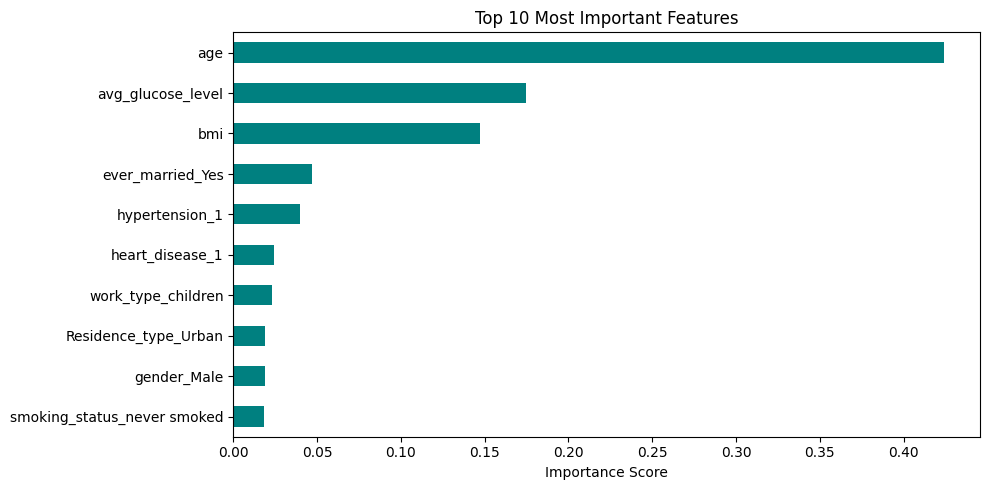

In [13]:
plt.figure(figsize=(10, 5))

# Extracting feature names after One-Hot Encoding
cat_feature_names = best_model.named_steps['preprocessor'].transformers_[1][1]\
                   .named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numerical_cols, cat_feature_names])

# Get Importance from the classifier inside the pipeline
importances = best_model.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=all_feature_names).nlargest(10)

feat_imp.sort_values().plot(kind='barh', color='teal')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance Score')
plt.savefig(f"images/top_10_most_important_features.png", bbox_inches="tight")
plt.tight_layout()
plt.show()

### 12. SHAP Analysis

In [14]:
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# Extract classifier from pipeline
best_pipeline = grid_search.best_estimator_
best_classifier = best_pipeline.named_steps['classifier']

# Transform test set
preprocessor = best_pipeline.named_steps['preprocessor']
X_test_transformed = preprocessor.transform(X_test)

# Get correct feature names after preprocessing
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    feature_names = X_test.columns

# Convert to DataFrame for SHAP
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Compute SHAP values
explainer = shap.TreeExplainer(best_classifier)
shap_values = explainer(X_test_transformed_df)

# Class 1 predictions
class1_indices = np.where(y_pred_tuned == 1)[0]

# Class 0 predictions
class0_indices = np.where(y_pred_tuned == 0)[0]

# Number of classes
num_classes = len(np.unique(y_train))

### 13. Waterfall plots
- The following sample of waterfall plots will give an idea visually of the main features that contributes to the final predicted value.
- However summary or bar plots are better for global feature importance across all predictions.


 SHAP Waterfall for class 1 prediction #1 (sample index 4)


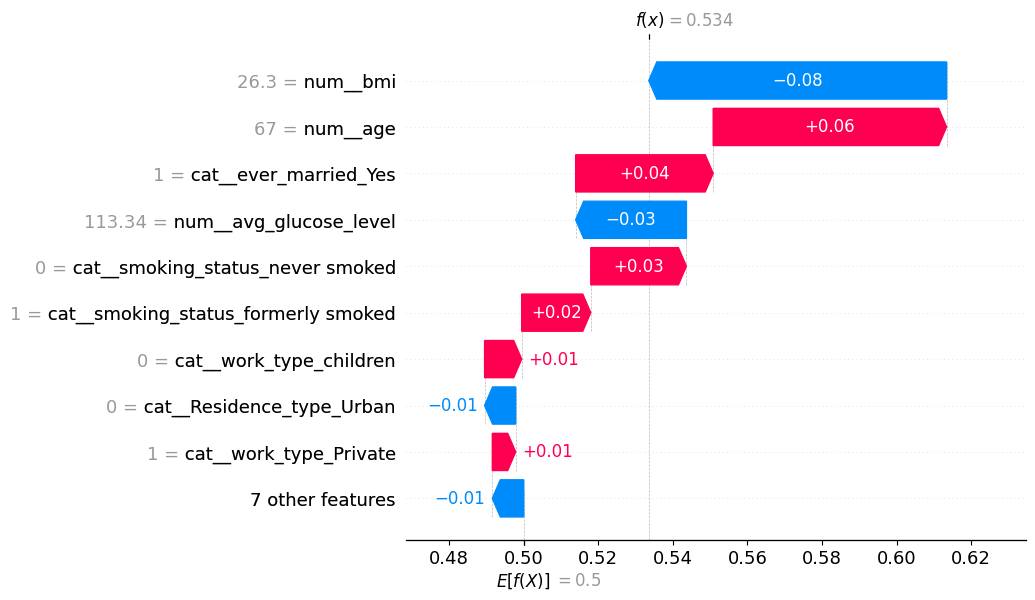


 SHAP Waterfall for class 1 prediction #2 (sample index 10)


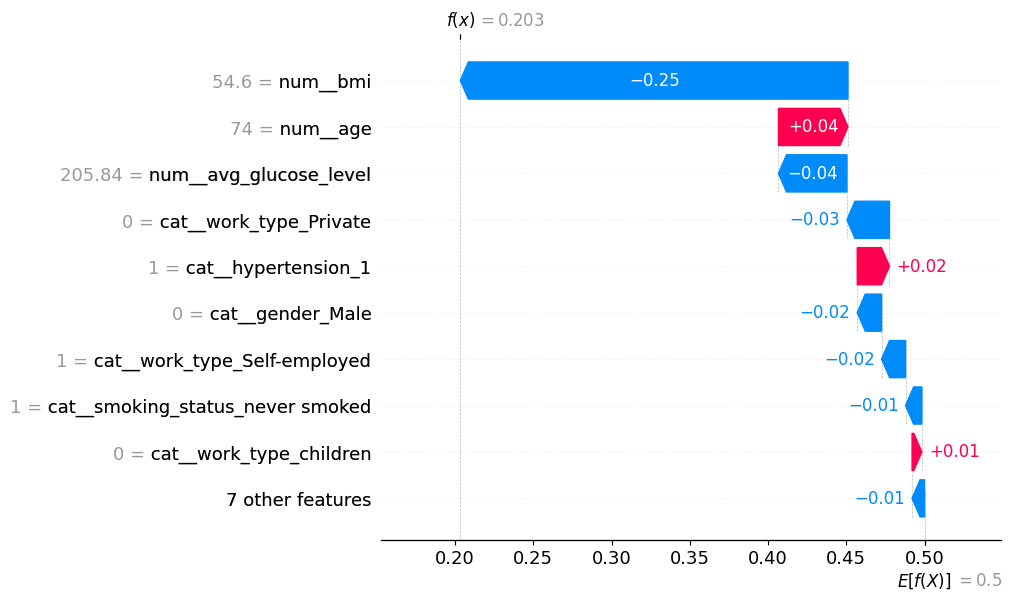


 SHAP Waterfall for class 1 prediction #3 (sample index 12)


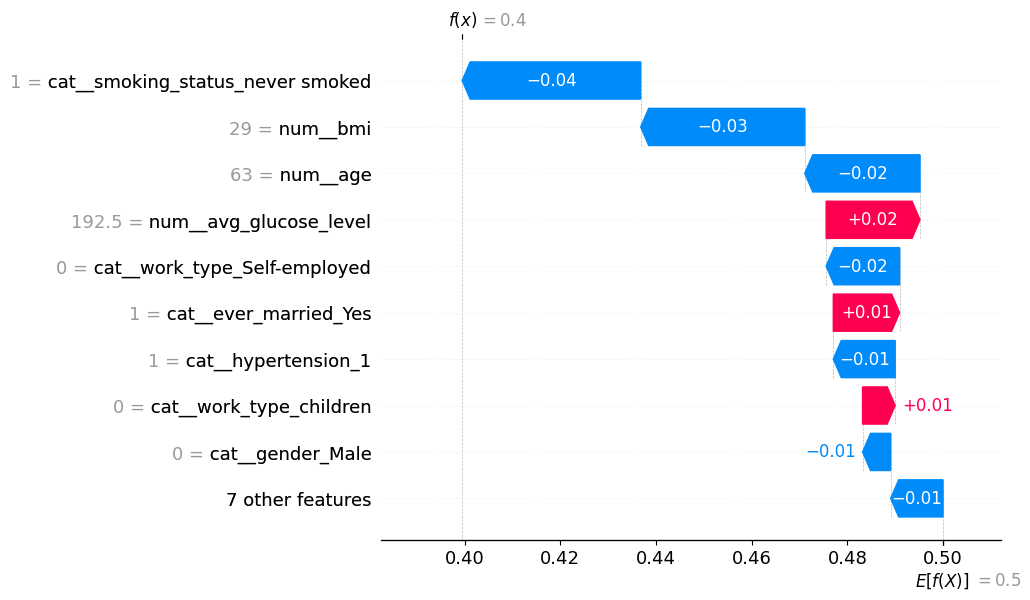


 SHAP Waterfall for class 1 prediction #4 (sample index 22)


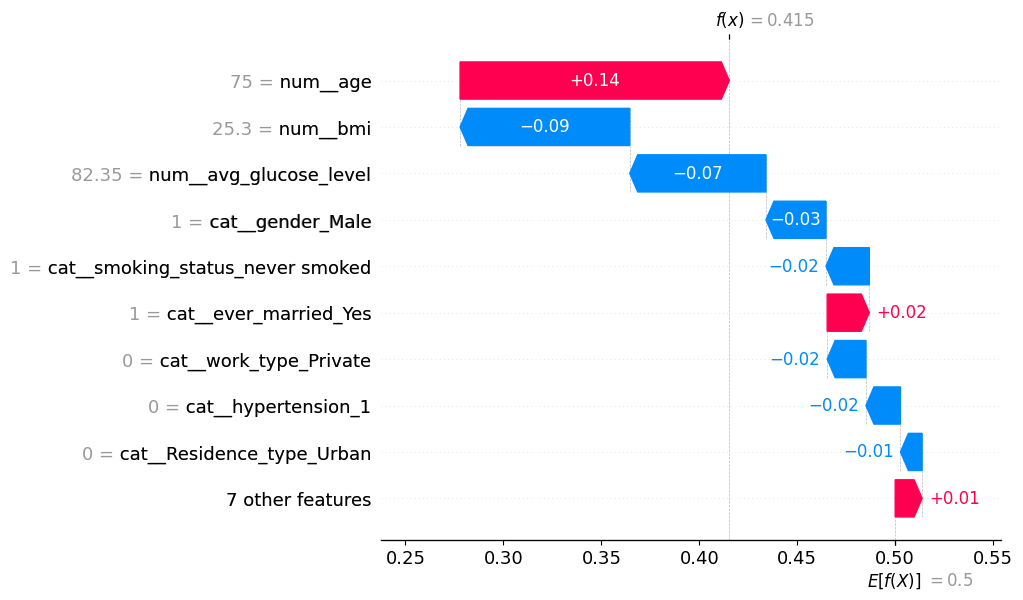


 SHAP Waterfall for class 1 prediction #5 (sample index 29)


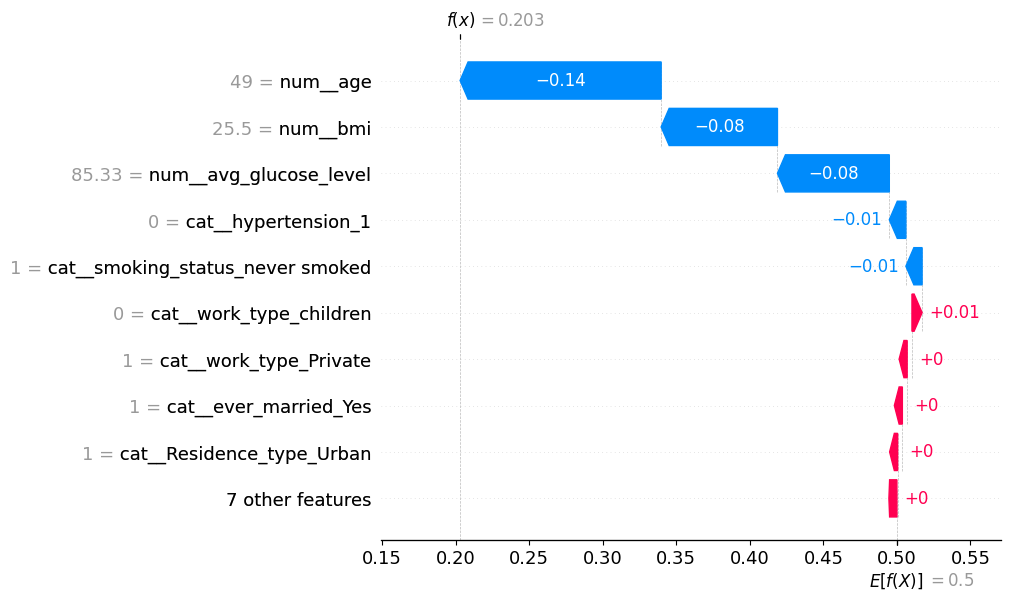

In [15]:
# Decide how many samples you want to plot
num_samples_to_plot = min(5, len(class1_indices))

if num_samples_to_plot == 0:
    print("No samples predicted as class 1 with threshold 0.2.")
else:
    # Loop over the first few class 1 predictions
    for i in range(num_samples_to_plot):
        idx = class1_indices[i]
        print(f"\n SHAP Waterfall for class 1 prediction #{i+1} (sample index {idx})")
        shap.plots.waterfall(shap_values[idx, :, 1])
        plt.show()

### 14. Bar plots


  SHAP Bar for class 0 prediction


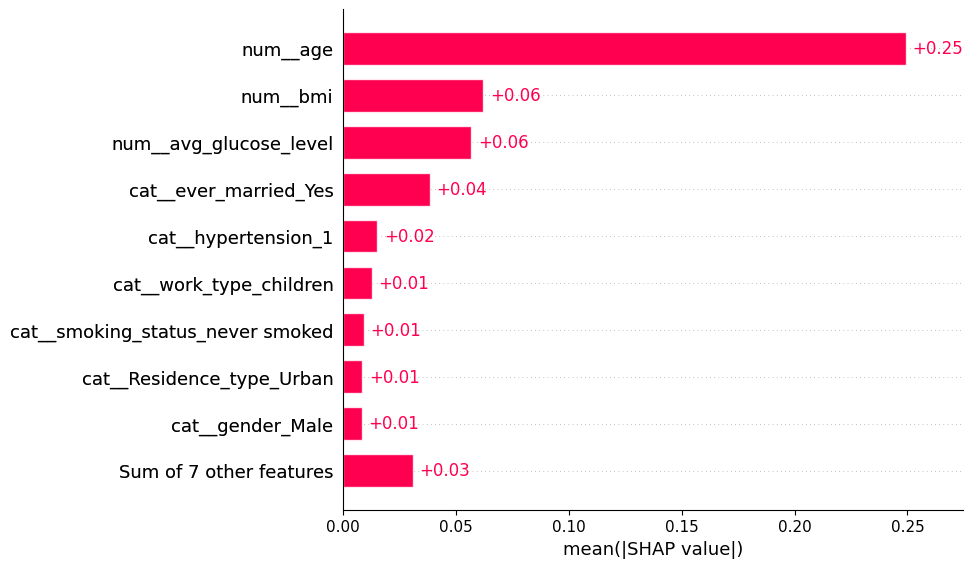


  SHAP Bar for class 1 prediction


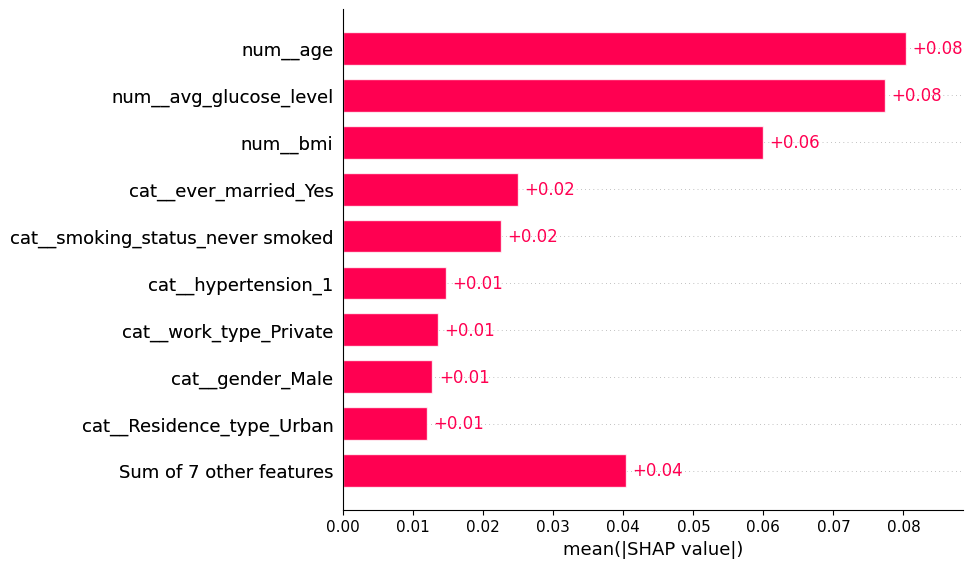

In [16]:
# Create a bar plot (global feature importance)
# Loop over stroke classes
for i in range(num_classes):
    class_indices = np.where(y_pred_tuned == i)[0]
    if len(class_indices) > 0:
        shap_class = shap_values[class_indices, :, 1]
        X_class1 = X_test_transformed_df.iloc[class_indices]

        print(f"\n  SHAP Bar for class {i} prediction")
        shap.plots.bar(shap_class, max_display=10)
    else:
        print(f"No samples predicted as class {i} with threshold 0.2.")

### 15. SHAP summary plot
- The summary plot showing the top 3 features that are contributing most to the prediction of a person having a stroke (class 1) are: age, average glucose level, and body mass index.
- Summary plot is a global explanation tool, unlike the waterfall plot which is per instance. It gives you a big-picture view of feature importance across your dataset.
- Aggregates SHAP values for all samples in your dataset.
- Shows which features contribute most to the model’s predictions overall.
- Each point represents a single feature value for one sample.
- Helps spot trends, feature importance, and correlations.


  SHAP Beeswarm for class 0 prediction


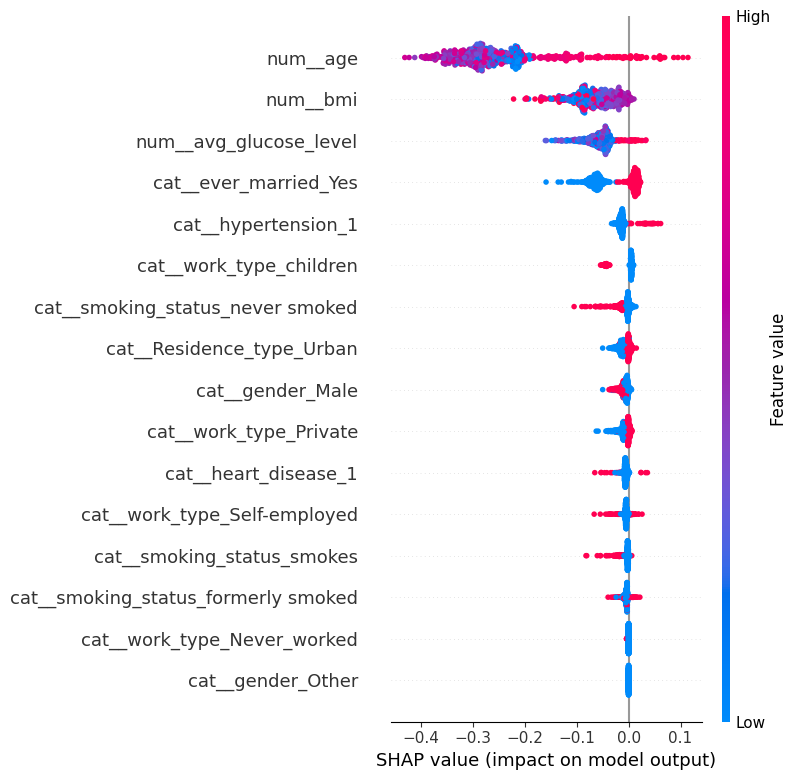


  SHAP Beeswarm for class 1 prediction


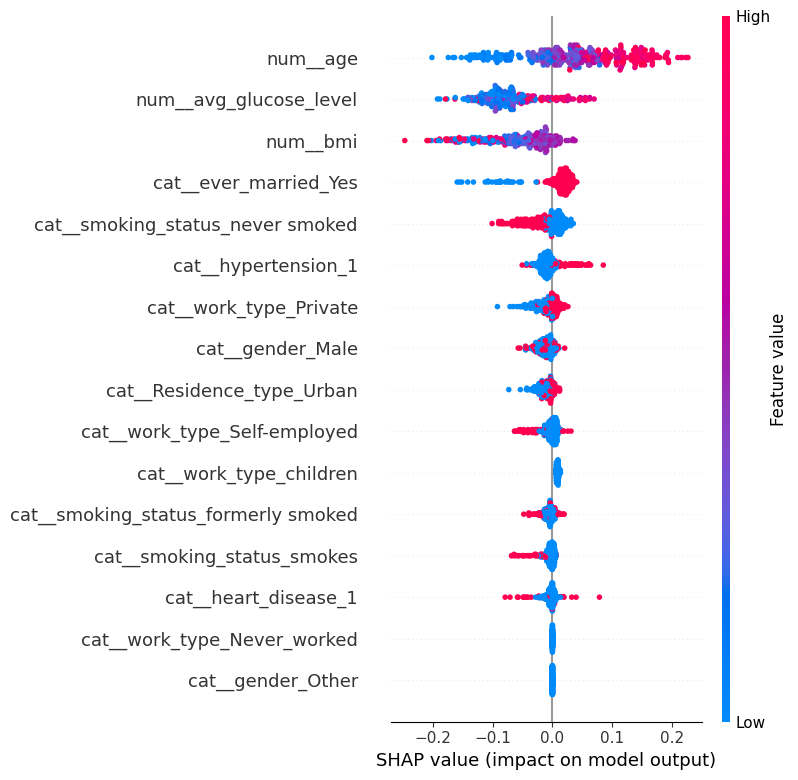

In [17]:
# Create a summary plot (global feature importance)
# Loop over stroke classes
for i in range(num_classes):
    class_indices = np.where(y_pred_tuned == i)[0]
    if len(class_indices) > 0:
        shap_class = shap_values[class_indices, :, 1]
        X_class = X_test_transformed_df.iloc[class_indices]

        print(f"\n  SHAP Beeswarm for class {i} prediction")
        shap.summary_plot(shap_class, X_class)
    else:
        print(f"No samples predicted as class {i} with threshold 0.2.")